In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import shap


In [2]:
df = pd.read_csv('byu_bb_players.csv')

In [3]:
df.head()

,ID,MP,PTS,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV
0,Michael Hall-2005,33.8,13.9,0.400,0.340,0.448,0.475,0.779,3.5,2.0,1.6,0.3,1.8
1,Austin Ainge-2005,27.7,9.5,0.429,0.345,0.513,0.515,0.788,2.9,4.1,1.1,0.0,3.2
2,Jared Jensen-2005,22.5,8.5,0.550,0.000,0.550,0.550,0.833,4.1,0.5,0.6,0.2,1.4
3,Mike Rose-2005,19.3,7.7,0.425,0.406,0.488,0.580,0.656,1.7,1.0,0.4,0.0,1.1
4,Keena Young-2005,22.2,7.2,0.497,0.000,0.507,0.497,0.608,5.6,0.7,0.6,0.7,0.9


In [4]:
X = df.drop('ID', axis=1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=scaler.get_feature_names_out())

In [5]:
isof = IsolationForest(n_estimators=200, contamination=.05)
isof.fit(X)

IsolationForest(contamination=0.05, n_estimators=200)

In [6]:
outlier = isof.predict(X)

In [7]:
n_outliers = (outlier == -1).sum()
pct_outliers = n_outliers/len(X)

print(n_outliers)
print(pct_outliers)


11
0.0514018691588785


In [8]:
scores = isof.decision_function(X)

In [9]:
df['outlier'] = (outlier == -1).astype(int)
df['anomaly_score'] = scores

In [10]:
df[df.outlier==1]

,ID,MP,PTS,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV,outlier,anomaly_score
66,Lamont Morgan Jr-2010,9.2,1.9,0.633,0.692,0.588,0.783,0.600,0.6,1.4,0.3,0.0,0.7,1,-0.000409
67,Jimmer Fredette-2011,35.8,28.9,0.452,0.396,0.491,0.533,0.894,3.4,4.3,1.3,0.0,3.5,1,-0.035329
76,James Anderson-2011,7.7,1.1,0.326,0.000,0.326,0.326,0.269,1.3,0.2,0.2,0.6,0.2,1,-0.010650
111,Kyle Collinsworth-2015,30.9,13.8,0.472,0.286,0.484,0.481,0.736,8.7,6.0,1.8,0.3,2.9,1,-0.011704
125,Kyle Collinsworth-2016,33.8,15.3,0.464,0.243,0.484,0.474,0.652,8.2,7.4,2.0,0.5,3.4,1,-0.085543
132,Jakob Hartsock-2016,6.0,1.3,0.262,0.278,0.167,0.381,0.000,1.2,0.2,0.1,0.1,0.2,1,-0.035251
133,Eric Mika-2017,28.6,20.3,0.528,0.000,0.530,0.528,0.763,9.2,1.6,0.6,1.9,2.5,1,-0.032777
146,Yoeli Childs-2018,34.0,17.8,0.541,0.313,0.568,0.557,0.643,8.6,2.2,0.9,1.8,2.2,1,-0.010149
165,Yoeli Childs-2020,28.8,22.2,0.574,0.489,0.588,0.610,0.538,9.0,2.0,0.7,0.9,2.4,1,-0.013778
194,Fousseyni Traore-2023,24.8,12.9,0.607,1.000,0.605,0.608,0.758,7.8,1.5,0.7,0.7,2.2,1,-0.024335


In [ ]:
plot_vars = ['FG%', 'TOV', 'MP', 'TRB']

In [ ]:
plot_df = df[plot_vars + ['outlier']]

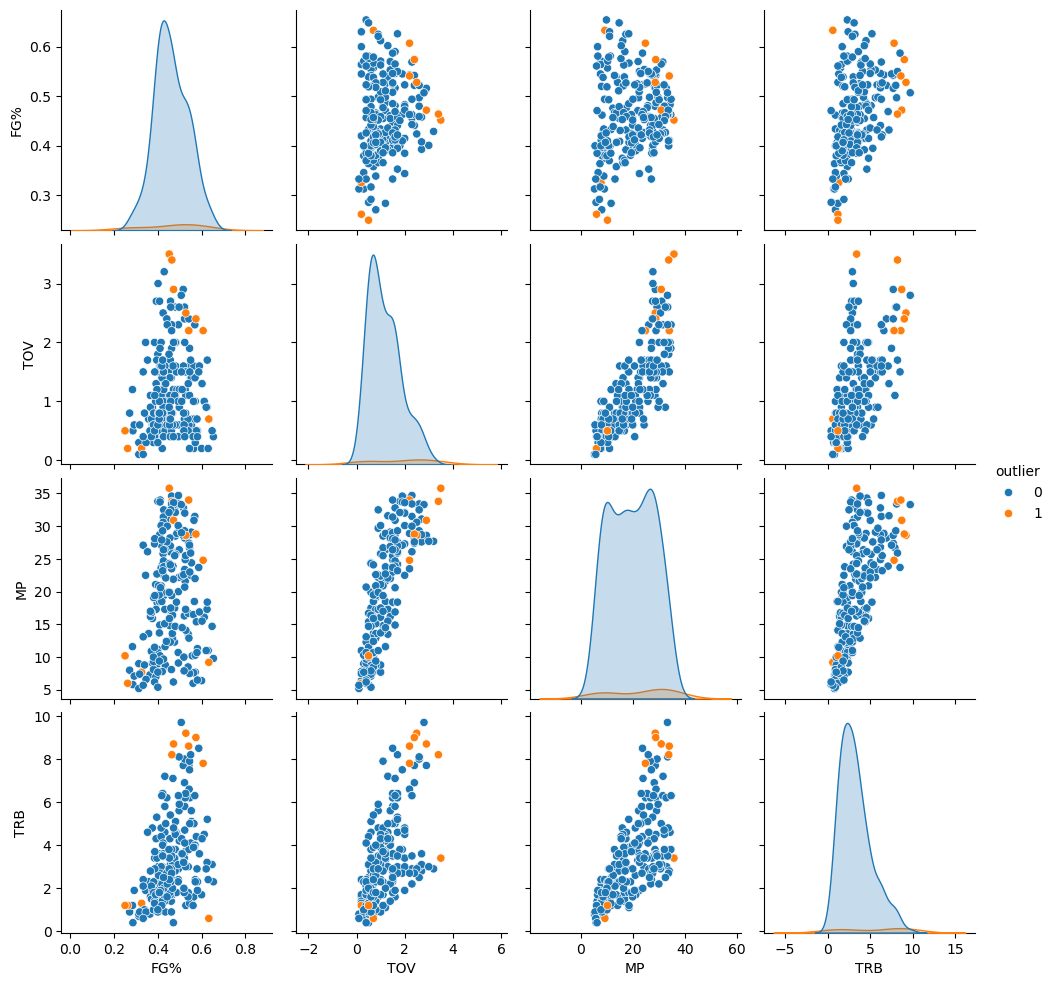

In [13]:
sns.pairplot(plot_df, hue='outlier')
plt.show()

In [14]:
model = RandomForestRegressor()
model.fit(X,scores)


RandomForestRegressor()

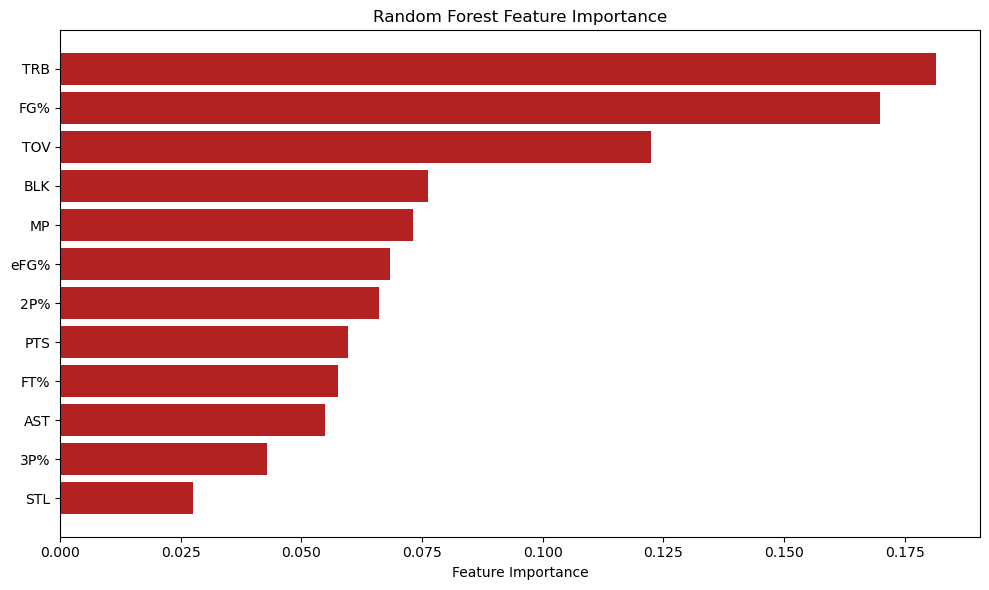

In [15]:
importances = model.feature_importances_
feature_names = X.columns

feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'], color='firebrick')
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()  # Highest importance at top
plt.tight_layout()
plt.show()

In [16]:
outliers = X[df.outlier == 1]

In [17]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X, check_additivity=False)

In [18]:
exp = shap.Explanation(shap_values, shap_values.base_values, X, feature_names=X.columns)


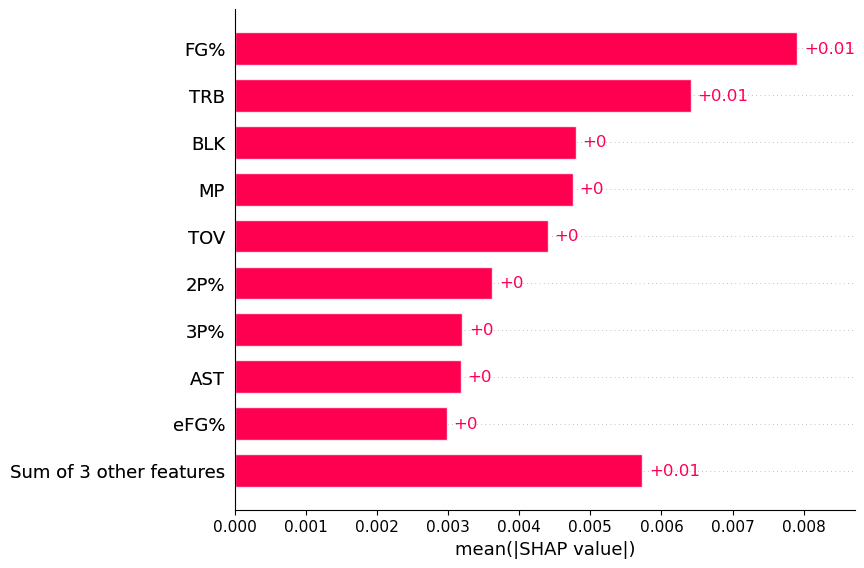

In [19]:
shap.plots.bar(exp)



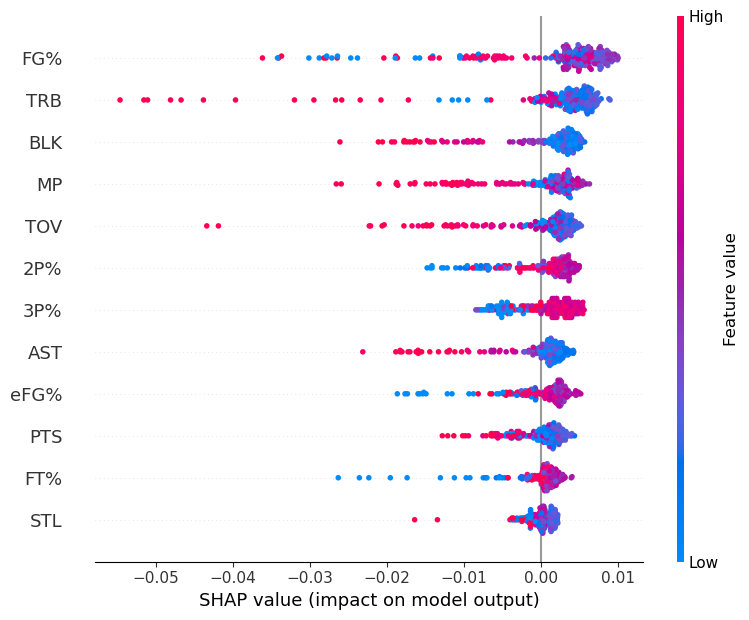

In [20]:
shap.summary_plot(exp)

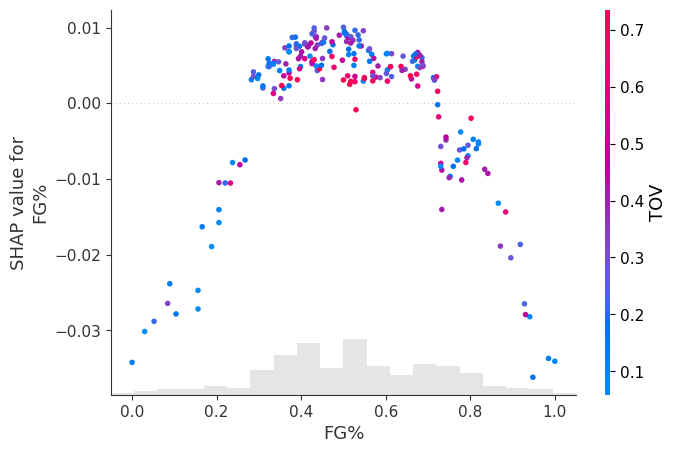

In [21]:
shap.plots.scatter(exp[:,'FG%'], color=exp)

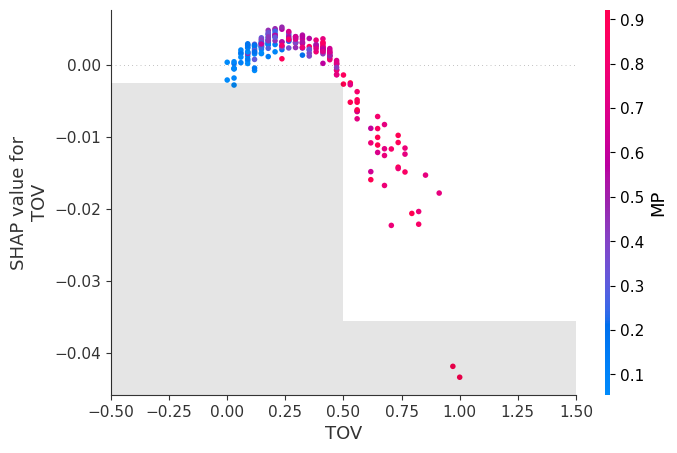

In [29]:
shap.plots.scatter(exp[:,'TOV'], color=exp[:,'MP'])

In [22]:
outlier_index = df[df['outlier']==1].index

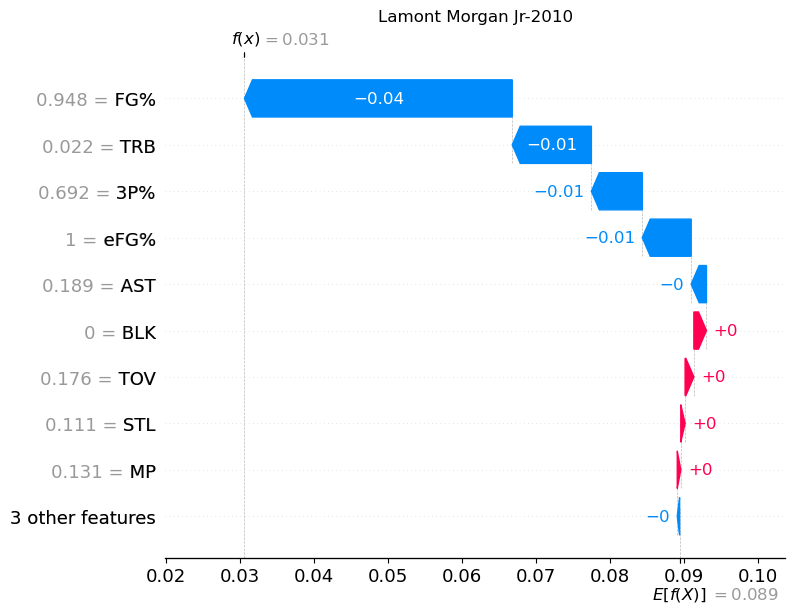

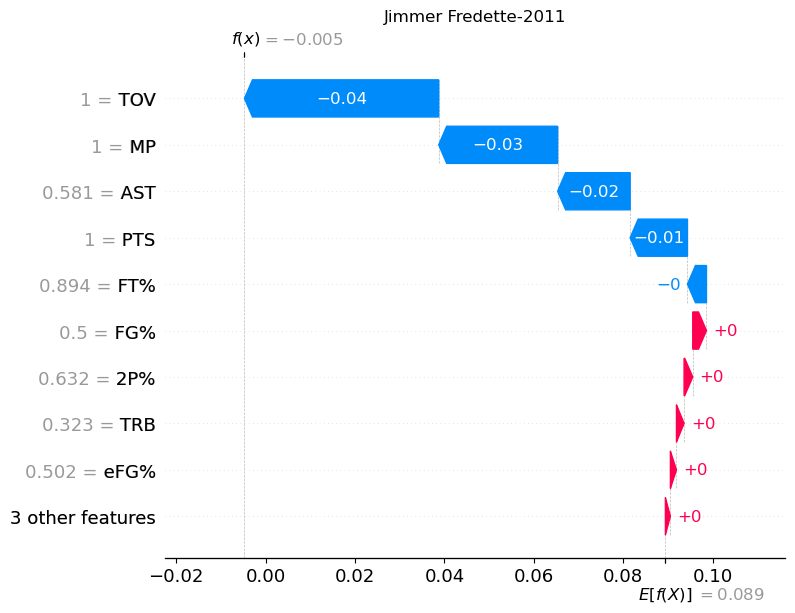

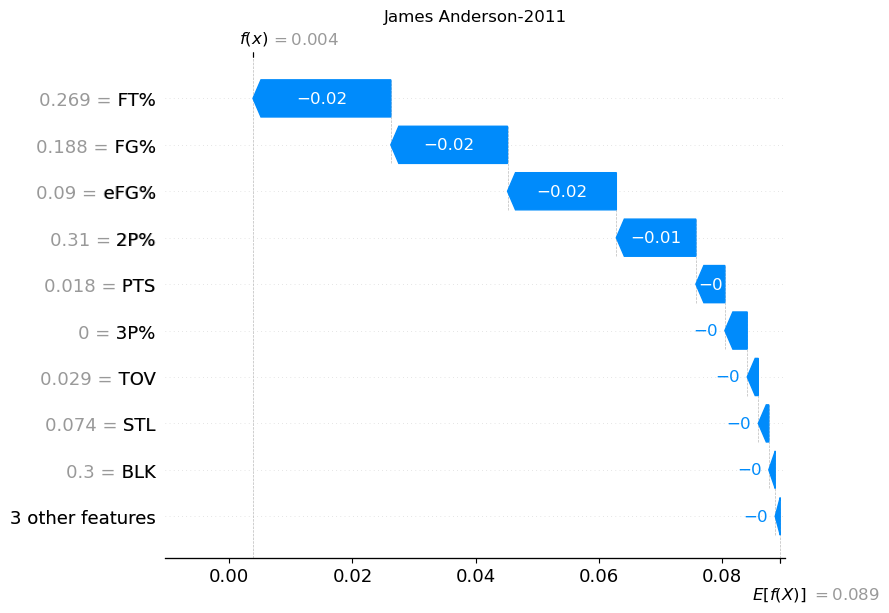

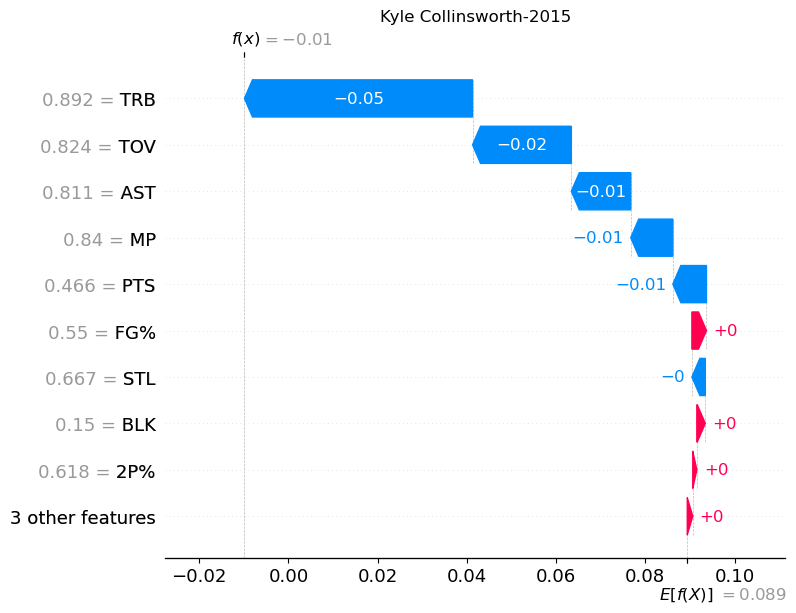

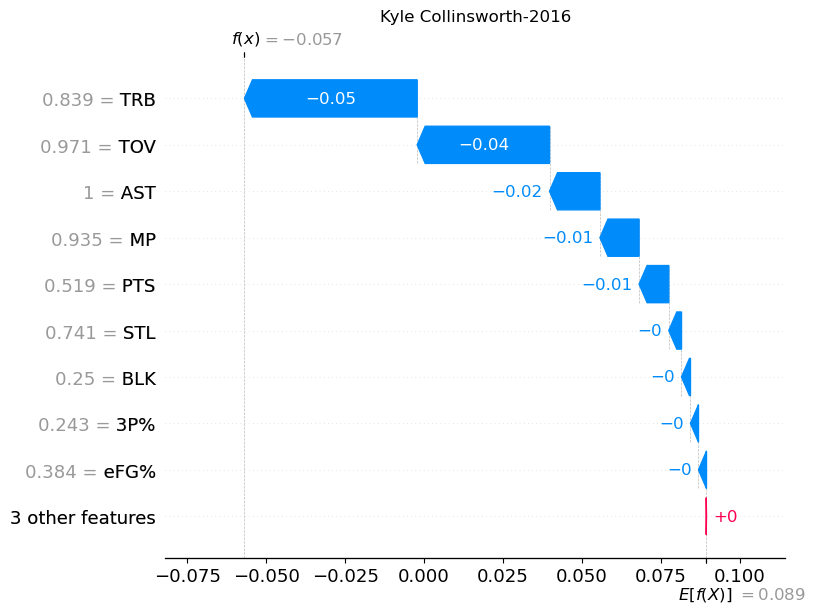

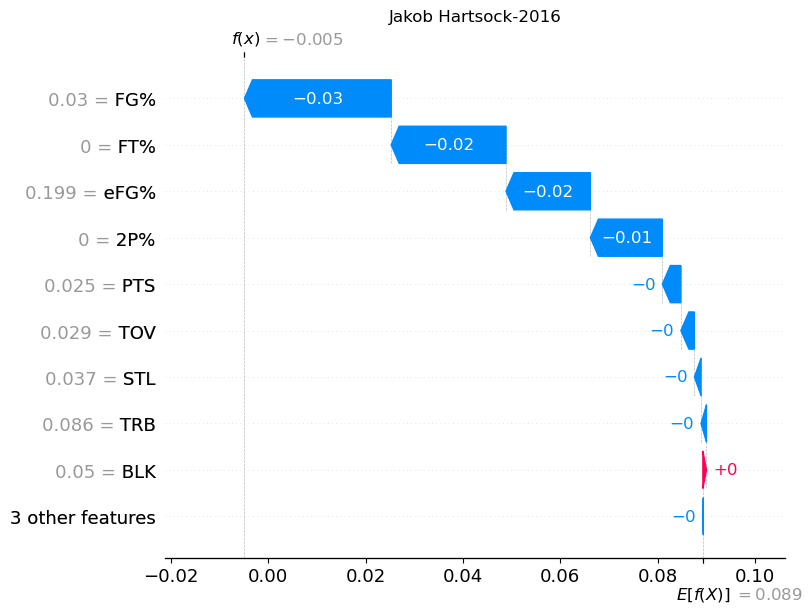

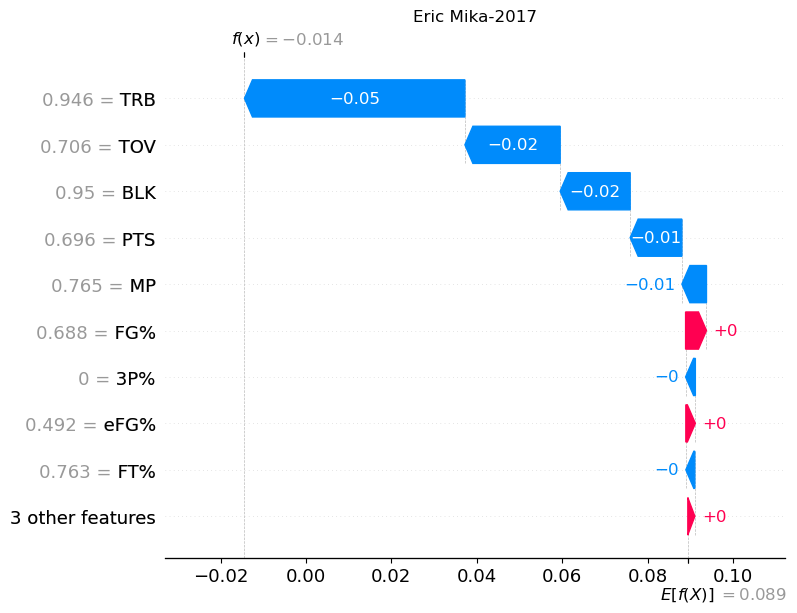

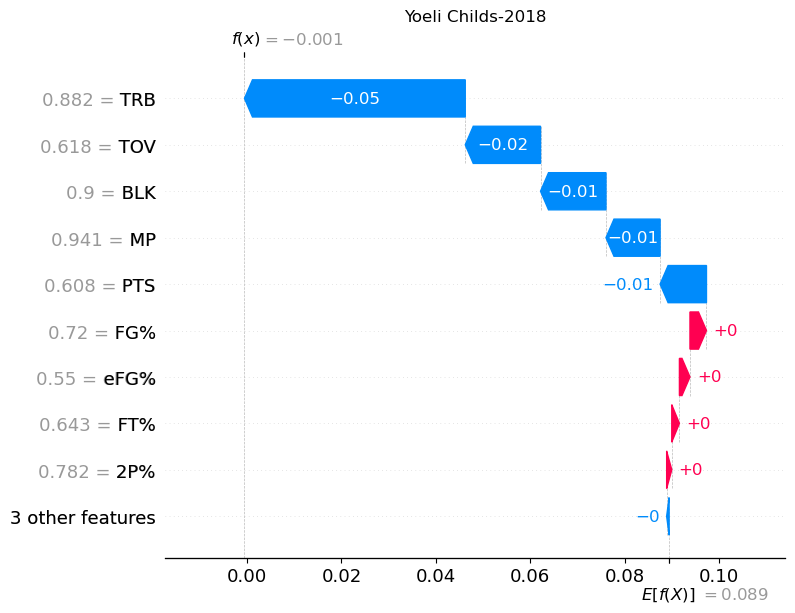

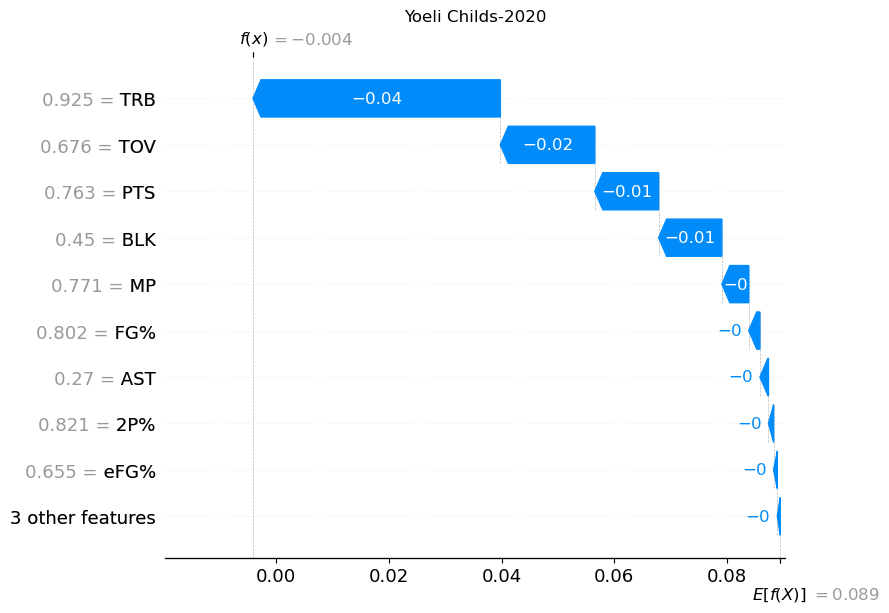

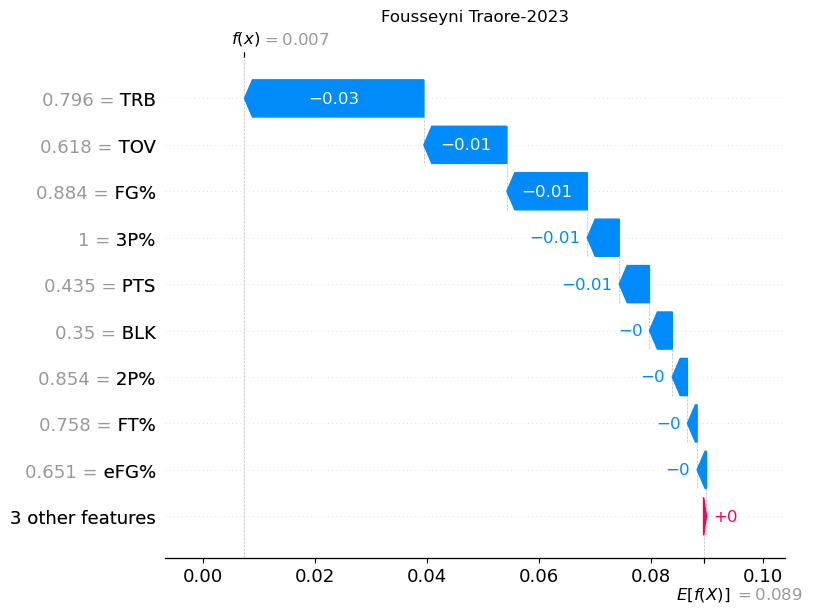

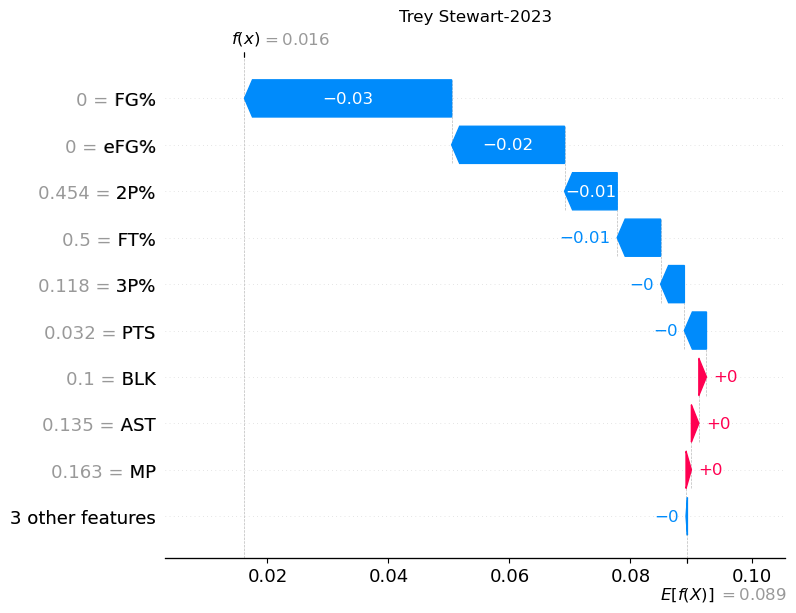

In [23]:
for i in outlier_index:
    fig = plt.figure()
    shap.plots.waterfall(exp[i], show = False)
    plt.title(f"{df.loc[i,'ID']}")
    plt.show()

In [24]:
outlier_mask = np.array(df['outlier']==1)
normal_mask = np.array(df['outlier']==0)

In [25]:
outliers = X[outlier_mask]
normals = X[normal_mask]

In [26]:
shap_values_outliers = shap_values.values[outlier_mask]
shap_values_normals = shap_values.values[normal_mask]

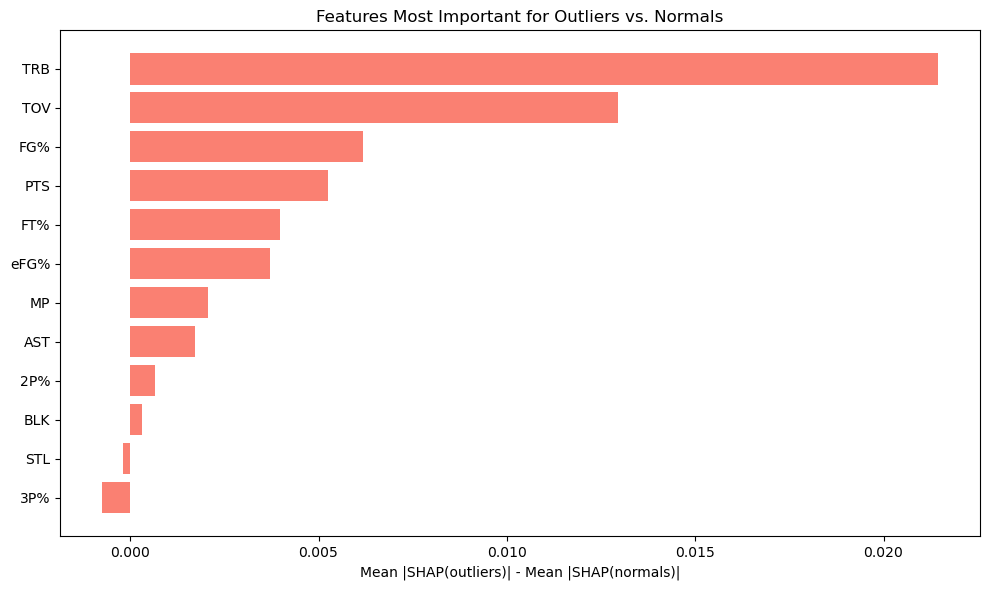

In [28]:
mean_shap_outliers = np.abs(shap_values_outliers).mean(axis=0)
mean_shap_normals = np.abs(shap_values_normals).mean(axis=0)
shap_diff = mean_shap_outliers - mean_shap_normals

diff_df = pd.DataFrame({
    'Feature': X.columns,
    'Outliers': mean_shap_outliers,
    'Normals': mean_shap_normals,
    'Difference': shap_diff
}).sort_values(by='Difference', ascending=False)

# Bar plot of top differing features
plt.figure(figsize=(10, 6))
plt.barh(diff_df['Feature'].head(15), diff_df['Difference'].head(15), color='salmon')
plt.xlabel("Mean |SHAP(outliers)| - Mean |SHAP(normals)|")
plt.title("Features Most Important for Outliers vs. Normals")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()